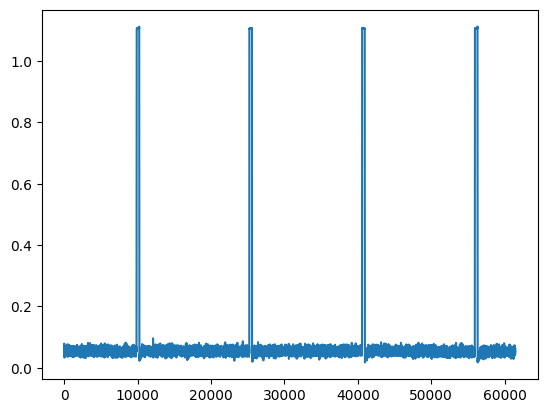

 samples size : 61426
rising edge idx [0] : 9851
 stateful index : 0
SNR : 16.642318395074238
 ppm : 124.7386052177444
stateful index incrementer: 61440
*****************************************


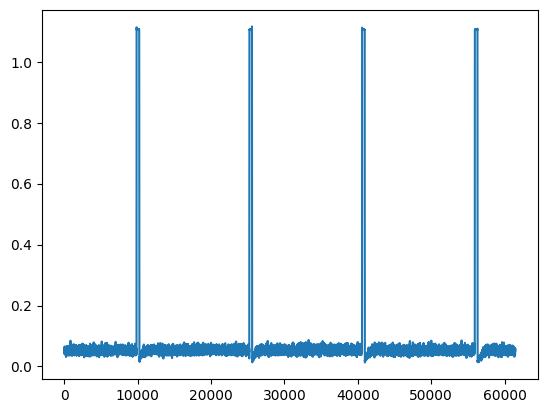

 samples size : 61426
rising edge idx [0] : 9849
 stateful index : 61440
SNR : 16.655356200631502
 ppm : 20.00065106286012
stateful index incrementer: 122880
*****************************************


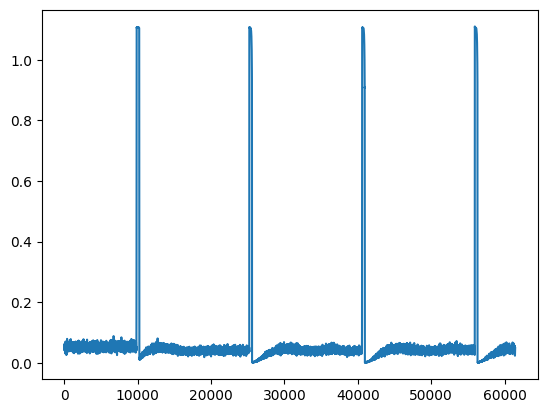

 samples size : 61426
rising edge idx [0] : 9847
 stateful index : 122880
SNR : 17.019332648324895
 ppm : 20.00065106286012
stateful index incrementer: 184320
*****************************************


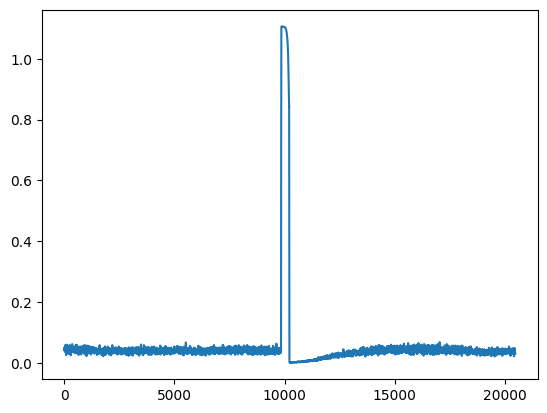

 samples size : 20466
rising edge idx [0] : 9846
 stateful index : 184320
SNR : 26.78916185367132
 ppm : 20.000325526131608
stateful index incrementer: 204800
*****************************************


In [16]:
import numpy as np
import scipy
from pylab import * 
from scipy import signal
from matplotlib import pyplot as plt
samples = np.load('log_v20.npy')
#iq_fc32 = samples.astype(np.complex64)
#with open('samples.fc32', 'wb') as f: 
#    f.write(iq_fc32.tobytes())

def snr(samples, rising_edge_idx, falling_edge_idx):
    noise_pwr = np.var( np.concatenate([samples[:rising_edge_idx], samples[falling_edge_idx:]]) )
    signal_pwr = np.var ( samples[rising_edge_idx:falling_edge_idx] )
    snr_db = 10 * np.log10 ( signal_pwr / noise_pwr )
    return snr_db

def sample_processor(samples):
    global stateful_index
    global stateful_rising_edge
    sample_rate = 2.048e6
    center_freq: float = 160270968
    freq_offset: float = -43.6792e4 #Hz
    #freq_offset: float = -16.8762e4 #Hz
    threshold = 0.9

    t = np.arange(len(samples))/sample_rate
    samples = samples * np.exp(2j*np.pi*t*freq_offset)
    h = signal.firwin(501, 0.02, pass_zero=True)
    samples = np.convolve(samples, h, 'valid')
    samples = samples[::100]
    sample_rate = sample_rate/100

    max_samples = np.abs(samples)
    max_samples = np.convolve(max_samples, [1]*10, 'valid')/10
    plt.plot(max_samples)
    show()
    low_samples = max_samples < threshold
    high_samples = max_samples >= threshold
    rising_edge_idx = np.nonzero(low_samples[:-1] & np.roll(high_samples, -1)[:-1])[0]
    falling_edge_idx = np.nonzero(high_samples[:-1] & np.roll(low_samples, -1)[:-1])[0]
    if len(rising_edge_idx) == 0 or len(falling_edge_idx) == 0:
        stateful_index += max_samples.size + 14
        print(f"stateful index incrementer early : {stateful_index}")  
        print("*********************")
        return
        #print(f"passed len test for idx's")
    if rising_edge_idx[0] > falling_edge_idx[0]:
        falling_edge_idx = falling_edge_idx[1:]

        # Remove stray rising edge at the end
    if rising_edge_idx[-1] > falling_edge_idx[-1]:
        rising_edge_idx = rising_edge_idx[:-1]

    #print(f"stateful rising edge : {stateful_rising_edge}")
    print(f" samples size : {max_samples.size}")
    print(f"rising edge idx [0] : {rising_edge_idx[0]}")
    print(f" stateful index : {stateful_index}")

    samples_between =  (rising_edge_idx[0]+stateful_index) - stateful_rising_edge
    time_between = 1/sample_rate * samples_between
    pulse_per_minute = 60 / time_between
    stateful_rising_edge = stateful_index + rising_edge_idx[0]
    print(f"SNR : {snr(samples, rising_edge_idx[0]-10, falling_edge_idx[0]+10)}")
    print(f" ppm : {pulse_per_minute}")

    # increment sample count
    stateful_index += max_samples.size + 14
    print(f"stateful index incrementer: {stateful_index}")
    print("*****************************************")   

def sample_plt(samples):
    global stateful_index
    global stateful_rising_edge
    sample_rate = 2.048e6
    center_freq: float = 160270968
    freq_offset: float = -43.6792e4 #Hz
    #freq_offset: float = -16.8762e4 #Hz
    threshold = 0.9

    t = np.arange(len(samples))/sample_rate
    samples = samples * np.exp(2j*np.pi*t*freq_offset)
    h = signal.firwin(501, 0.02, pass_zero=True)
    samples = np.convolve(samples, h, 'valid')
    samples = samples[::100]
    sample_rate = sample_rate/100
    samples = np.abs(samples)
    samples = np.convolve(samples, [1]*10, 'valid')/10
    print(samples.size)
    lines = np.linspace(0, 204786, 21)
    print(lines)
    for l in lines:
        plt.axvline(x=l)
        plt.plot(samples)
    show()

stateful_index = 0
stateful_rising_edge = 0

#sample_plt(samples)

for ix in range (0, samples.size, 6144000):
    samples_ = samples[ix:ix+6144000]
    sample_processor(samples_)

In [31]:
from rtlsdr import RtlSdr
import numpy as np
sdr = RtlSdr()

# configure device
sdr.sample_rate = 2.048e6  # Hz
sdr.center_freq = 160.270968e6     # Hz
#sdr.freq_correction = 60   # PPM
sdr.gain = 22.9

samples = sdr.read_samples(20480000)

np.save('log_v20.npy', samples)
sdr.close()
